In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('datasets/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
train_df = pd.get_dummies(train_df, columns=['Sex']).drop(columns='Sex_female')
train_df = train_df.fillna({'Age': train_df['Age'].median()})
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [4]:
from data import normalize_columns
normalize_columns(train_df, columns=['Age', 'Fare'])
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,0.271174,0.014151,1
1,1,1,0.472229,0.139136,0
2,1,3,0.321438,0.015469,0
3,1,1,0.434531,0.103644,0
4,0,3,0.434531,0.015713,1


In [5]:
X = train_df.drop(columns='Survived')
y = train_df['Survived']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Самописный градиентный спуск + логистическая регрессия

In [7]:
from linear import StandardGradientDescent
from quality_functional import LogisticLoss
from quality_functional import Accuracy

accs = []

for S in range(10, 1000, 10):
    gd = StandardGradientDescent(alpha=0.005, S=S, loss=LogisticLoss)
    gd.fit(X_train, y_train)
    y_pred = gd.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accs.append(Accuracy.get_accuracy(y_pred, y_test))

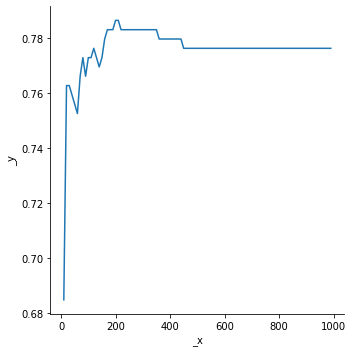

In [8]:
import seaborn as sns
sns.relplot(x=list(range(10, 1000, 10)), y=accs, kind='line')

Оптимальное S = ~200

In [9]:
gd = StandardGradientDescent(alpha=0.001, S=180, loss=LogisticLoss)
gd.fit(X_train, y_train)
y_pred = gd.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
Accuracy.get_accuracy(y_pred, y_test)

0.7593220338983051

In [10]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [12]:
predicts_df = pd.DataFrame(test_df['PassengerId'])

In [13]:
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
test_df = pd.get_dummies(test_df, columns=['Sex']).drop(columns='Sex_female')
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Age'].mean()})
normalize_columns(test_df, columns=['Age', 'Fare'])
test_df.head()

,Pclass,Age,Fare,Sex_male
0,3,0.452723,0.015282,1
1,3,0.617566,0.013663,0
2,2,0.815377,0.018909,1
3,3,0.353818,0.016908,1
4,3,0.287881,0.023984,0


In [14]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)

In [15]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат ~0.73, но включив фичу Fare результат возрос до 0.767

# Логистическая регрессия sklearn

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
lr = LogisticRegression(penalty='none')

In [18]:
lr.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [19]:
Accuracy.get_accuracy(lr.predict(X_test), y_test)

0.7796610169491526

In [20]:
predicts_df['Survived'] = lr.predict(test_df)

In [21]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат без регуляризации ~0.74

Попробую улучшить результат, варьируя различные параметры этой модели

In [22]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [23]:
lr.fit(X_train, y_train)
Accuracy.get_accuracy(lr.predict(X_test), y_test)

0.7694915254237288

In [24]:
predicts_df['Survived'] = lr.predict(test_df)
predicts_df.to_csv('predicts.csv', index=False)

### L1-регуляризация здесь показала лучший результат, чем L2 (~0.76 против ~0.75)

# Исследуем датасет поглубже

In [25]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [26]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [27]:
titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'SibSp', 'Parch'])
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,3,male,22.0,7.2500,NaN
1,1,1,female,38.0,71.2833,C85
2,1,3,female,26.0,7.9250,NaN
3,1,1,female,35.0,53.1000,C123
4,0,3,male,35.0,8.0500,NaN


Стобец PassengerId точно не несет в себе полезной информации, также как столбцы Ticket и Name.
Столбцы Pclass, Sex, Age и Fare мы уже использовали.
Происследуем столбец Cabin - было бы логично, что пассажиры, проживающие в нижних каютах имели меньший шанс на выживание.

In [28]:
titanic_df.isna().any()

Survived    False
Pclass      False
Sex         False
Age          True
Fare        False
Cabin        True
dtype: bool

Необходимо что-то сделать с пропусками в столбцах Age и Cabin. Как вариант - пропуски в Age заполнять медианными значениями, а объекты с пропусками в Cabin удалять.

In [29]:
titanic_df = titanic_df.fillna({'Age': titanic_df['Age'].median()})
titanic_df['Cabin'].isna().sum()

687

У большей части пассажиров неизвестны номера их кают - значит удалять их точно не вариант.

In [30]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Можно заметить, что у некоторых пассажиров встречаются сразу несколько номеров кают.
Согласно информации с сайта https://aif.ru/dontknows/infographics/paluby_i_kayuty_titanika_infografika, палуба A находилась в самом верху судна, а палуба G - в самом низу. Вряд ли из численной части номера можно вытащить полезную информацию, в отличии от буквы.

Палуб (и соответственно букв) конечное число, поэтому можно породить категариальный признак Deck, который затем двоично закодировать n-1 признаками. 
Также вознимкает идея считать пропуск отдельной категорией.

In [31]:
get_deck_from_cabin = lambda s: s[0] if type(s) == str else np.nan

In [32]:
titanic_df['Deck'] = titanic_df['Cabin'].apply(get_deck_from_cabin)
titanic_df['Deck'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [33]:
titanic_df = pd.get_dummies(titanic_df, columns=['Deck', 'Sex']).drop(columns=['Cabin', 'Sex_female', 'Deck_T'])
titanic_df.head()

,Survived,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,0,3,22.0,7.2500,0,0,0,0,0,0,0,1
1,1,1,38.0,71.2833,0,0,1,0,0,0,0,0
2,1,3,26.0,7.9250,0,0,0,0,0,0,0,0
3,1,1,35.0,53.1000,0,0,1,0,0,0,0,0
4,0,3,35.0,8.0500,0,0,0,0,0,0,0,1


Нормализуем фичи Age и Fare

In [34]:
from data import normalize_columns
normalize_columns(titanic_df, columns=['Age', 'Fare'])
titanic_df.head()

,Survived,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,0,3,0.271174,0.014151,0,0,0,0,0,0,0,1
1,1,1,0.472229,0.139136,0,0,1,0,0,0,0,0
2,1,3,0.321438,0.015469,0,0,0,0,0,0,0,0
3,1,1,0.434531,0.103644,0,0,1,0,0,0,0,0
4,0,3,0.434531,0.015713,0,0,0,0,0,0,0,1


In [35]:
X_train = titanic_df.drop(columns='Survived')
y_train = titanic_df['Survived']

In [36]:
gd = StandardGradientDescent(alpha=0.005, S=200, loss=LogisticLoss)
gd.fit(X_train, y_train)

In [37]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'SibSp', 'Parch'])
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Fare'].mean()})
get_deck_from_cabin = lambda s: s[0] if type(s) == str else np.nan
test_df['Deck'] = test_df['Cabin'].apply(get_deck_from_cabin)
test_df = pd.get_dummies(test_df, columns=['Deck', 'Sex']).drop(columns=['Cabin', 'Sex_female'])
normalize_columns(test_df, columns=['Age', 'Fare'])
test_df

,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,3,0.452723,0.015282,0,0,0,0,0,0,0,1
1,3,0.617566,0.013663,0,0,0,0,0,0,0,0
2,2,0.815377,0.018909,0,0,0,0,0,0,0,1
3,3,0.353818,0.016908,0,0,0,0,0,0,0,1
4,3,0.287881,0.023984,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
413,3,0.353818,0.015713,0,0,0,0,0,0,0,1
414,1,0.512066,0.212559,0,0,1,0,0,0,0,0
415,3,0.505473,0.014151,0,0,0,0,0,0,0,1
416,3,0.353818,0.015713,0,0,0,0,0,0,0,1


In [38]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [39]:
predicts_df.to_csv('predicts.csv', index=False)

## Результат дотянул до моего рекордного 0.77272, но не улучшился :(

Исследуем числовые признаки

<AxesSubplot:xlabel='Age'>

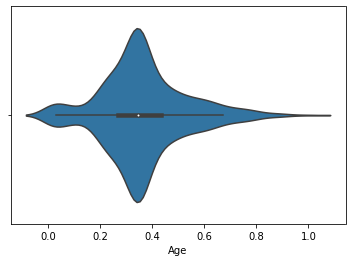

In [40]:
sns.violinplot(x=titanic_df['Age'])

<AxesSubplot:xlabel='Fare'>

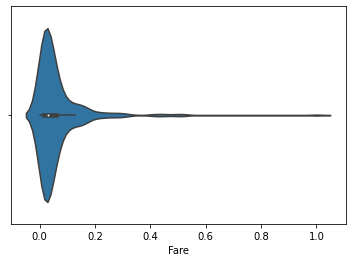

In [41]:
sns.violinplot(x=titanic_df['Fare'])

Можно удалить данные, в которых Fare превышает, например, 0.3

In [42]:
titanic_df = titanic_df.query('Fare < 0.3')

In [44]:
X_train = titanic_df.drop(columns='Survived')
y_train = titanic_df['Survived']

In [45]:
gd = StandardGradientDescent(alpha=0.005, S=200, loss=LogisticLoss)
gd.fit(X_train, y_train)

In [46]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [47]:
predicts_df.to_csv('predicts.csv', index=False)

## Результат нисколько не улучшился

Попробуем логистическую регрессию из sklearn

In [198]:
lr = LogisticRegression(penalty='l2')

In [200]:
lr.fit(X_train, y_train)

LogisticRegression()

In [205]:
predicts_df['Survived'] = lr.predict(test_df)
predicts_df.to_csv('predicts.csv', index=False)

## Результат ухудшился до ~0.75

Попробуем теперь учитывать признаки SibSp и ParCh, и не учитывать Cabin

In [246]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')
titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
titanic_df = titanic_df.fillna({'Age': titanic_df['Age'].median()})
titanic_df = pd.get_dummies(titanic_df, columns=['Sex']).drop(columns='Sex_female')
normalize_columns(titanic_df, columns=['Age', 'Fare'])
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25)

In [247]:
gd = StandardGradientDescent(alpha=0.005, S=200, loss=LogisticLoss)
gd.fit(X_train, y_train)

In [248]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Fare'].mean()})
test_df = pd.get_dummies(test_df, columns=['Sex']).drop(columns=['Sex_female'])
normalize_columns(test_df, columns=['Age', 'Fare'])

In [249]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.to_csv('predicts.csv', index=False)

## Результат не улучшился

Попробуем из признаков SibSp и Parch породить новый признак Family

In [252]:
titanic_df['Family'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df = titanic_df.drop(columns=['SibSp', 'Parch'])
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25)

In [253]:
gd = StandardGradientDescent(alpha=0.005, S=200, loss=LogisticLoss)
gd.fit(X_train, y_train)

In [254]:
test_df['Family'] = test_df['SibSp'] + test_df['Parch']
test_df = test_df.drop(columns=['SibSp', 'Parch'])

In [256]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.to_csv('predicts.csv', index=False)

## Результат улучшился совсем немного - до 0.77751